This is the notebook to test out new stuff with regards to divergence unmixing

In [55]:
%load_ext autoreload
%autoreload 2

# Define autroreload so that it doesn't cause pain in the ass when we change the functions and run this notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# Define the relative paths, append it to the system path
import sys
from pathlib import Path

github_root = Path.cwd().resolve().parents[1] # We will use this root to import our functions
sys.path.append(str(github_root))

# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import functions
from Unmixing_Methods.Unconventional_Unmixing_Methods.divergence import *
from Unmixing_Methods.Auxiliary_to_Unmixing_Methods.plotting_functions import *



In [57]:
# Data generation options go here

SNR_Options = [100,120,140,160,180,200,220,240,260,280]

VZA_SNR_Options = [100,120,140,160,180,200,220,240,260,280]

VZA_Options = [120,140,155]

Best_EM_Choice = [1438, 1054, 1377] #refer indices to the simpler_data_rwc
Worst_EM_Choice = [1438, 356, 1395] #same as EM_Choice, but the worst choices now

EM_Choice = [1438, 1054, 1395]

Spectra_Range_Index = [117,132  +1] #selected range: 1500-1650, refer indices to a dataset that has rwc columns and no original indices column
                                # WARNING!!!! Write the last index +1 since python slicing STOPS at that last index and DOES NOT include it (THIS IS RELATED TO PYTHON, WILL NOT CHANGE)
                                # for 900-1700, 57,137
                                # for 1500-1650, 117, 132

simpler_data_rwc_handle = r"C:\SenkDosya\UTAT\Data\General_Data\simpler_data_rwc.csv" # PATH HANDLE for simpler_data_snr goes here keep .csv
simpler_data_snr_handle = r"C:\SenkDosya\UTAT\Data\General_Data\Noised_Data\simpler_data_SNR_" # PATH HANDLE for simpler_data_snr goes here omit the SNR VAL and .csv
conference_data_vza_handle = r"C:\SenkDosya\UTAT\Data\Conference_Data\csrs2025_" # PATH HANDLE for csrs2025_VZA goes here omit the VZA and .csv
conference_data_vza_snr_handle = r"C:\SenkDosya\UTAT\Data\Conference_Data\Noised_155_csrs2025\155_csrs2025_SNR_" # PATH HANDLE for 155 VZA varying SNR goes here omit the VZA and .csv

In [58]:
# Actual data manipulation

for i in SNR_Options:
    
    globals()[f'lib_SNR_{i}'] = pd.read_csv(rf"{simpler_data_snr_handle+str(i)}.csv")

    # Extract abundances for the entire dataset
    if  SNR_Options[0]== i:
        true_abundances_matrix_all = (globals()[f'lib_SNR_{i}'].iloc[:, 1:4]).to_numpy() #create the abundances matrix here
        print("Abundance MATRIX for ALL, COMPLETE.")
    
    globals()[f'values_lib_SNR_{i}'] = (globals()[f'lib_SNR_{i}'].iloc[:, Spectra_Range_Index[0]-2:Spectra_Range_Index[1]-2]).to_numpy()
    del globals()[f'lib_SNR_{i}']
 # -2 since SNR does not have rwc, THIS MAY CHANGE IN THE FUTURE

print("SNR data generation, COMPLETE.")

for i in VZA_Options:
    
    globals()[f'lib_VZA_{i}'] = pd.read_csv(rf"{conference_data_vza_handle+str(i)}.csv")

    # Extract abundances for the conference dataset
    if VZA_Options[0] == i:
        true_abundances_matrix_conf = (globals()[f'lib_VZA_{i}'].iloc[:,2:5]).to_numpy()
        print("Abundance MATRIX for CONFERENCE, COMPLETE.")

    globals()[f'values_lib_VZA_{i}'] = ((globals()[f'lib_VZA_{i}'].iloc[:, Spectra_Range_Index[0]+1:Spectra_Range_Index[1]+1])).to_numpy() #+1 since these datasets have a index referral column, this WILL NOT CHANGE IN THE FUTURE, MOST LIKELY
    del globals()[f'lib_VZA_{i}']

print("VZA data generation, COMPLETE.")

for i in VZA_SNR_Options:
    
    globals()[f'lib_155VZA_SNR_{i}'] = pd.read_csv(rf"{conference_data_vza_snr_handle+str(i)}.csv")

    # Extract abundances for the conference dataset
    if VZA_Options[0] == i:
        true_abundances_matrix_conf = (globals()[f'lib_155VZA_SNR_{i}'].iloc[:,2:5]).to_numpy()
        print("Abundance MATRIX for CONFERENCE, COMPLETE.")

    globals()[f'values_lib_155VZA_SNR_{i}'] = ((globals()[f'lib_155VZA_SNR_{i}'].iloc[:, Spectra_Range_Index[0]+1:Spectra_Range_Index[1]+1])).to_numpy() #+1 since these datasets have a index referral column, this WILL NOT CHANGE IN THE FUTURE, MOST LIKELY
    del globals()[f'lib_155VZA_SNR_{i}']

print("155 VZA varying SNR data generation, COMPLETE.")

# here, we have to pull the EM dataset that we'll use to unmix with, these shall not be tempered, we are cutting out the unuseful stuff
values_lib_em = ((pd.read_csv(simpler_data_rwc_handle)).iloc[EM_Choice, Spectra_Range_Index[0]:Spectra_Range_Index[1]]).to_numpy()

values_lib_em_worst = ((pd.read_csv(simpler_data_rwc_handle)).iloc[Worst_EM_Choice, Spectra_Range_Index[0]:Spectra_Range_Index[1]]).to_numpy()

print("EM data generation, COMPLETE.")

wavelengths = np.arange(1500, 1651, 10)
print("Wavelengths generated, COMPLETE.")

print("WARNING: All the outputs are in arrays.")


Abundance MATRIX for ALL, COMPLETE.
SNR data generation, COMPLETE.
Abundance MATRIX for CONFERENCE, COMPLETE.
VZA data generation, COMPLETE.
Abundance MATRIX for CONFERENCE, COMPLETE.
155 VZA varying SNR data generation, COMPLETE.
EM data generation, COMPLETE.
Wavelengths generated, COMPLETE.


In [ ]:
# Run the divergence unmixing on the SNR datasets

for i in SNR_Options:

    (globals()[f'abundances_IS_Reg_SNR_{i}']) = np.zeros((globals()[f'values_lib_SNR_{i}'].shape[0], 3)) #regular output
    (globals()[f'abundances_IS_Soft_SNR_{i}']) = np.zeros((globals()[f'values_lib_SNR_{i}'].shape[0], 3)) #softmax output
    (globals()[f'abundances_ISpdf_Reg_SNR_{i}']) = np.zeros((globals()[f'values_lib_SNR_{i}'].shape[0], 3)) #regular output
    (globals()[f'abundances_ISpdf_Soft_SNR_{i}']) = np.zeros((globals()[f'values_lib_SNR_{i}'].shape[0], 3)) #softmax output
    (globals()[f'abundances_KL_Reg_SNR_{i}']) = np.zeros((globals()[f'values_lib_SNR_{i}'].shape[0], 3)) #regular output
    (globals()[f'abundances_KL_Soft_SNR_{i}']) = np.zeros((globals()[f'values_lib_SNR_{i}'].shape[0], 3)) #softmax output

    for j in range(globals()[f'values_lib_SNR_{i}'].shape[0]):

        (globals()[f'abundances_IS_Reg_SNR_{i}'])[j] = divergence_unmixing(globals()[f'values_lib_SNR_{i}'][j,:].reshape(1,16), values_lib_em, compute_option='Itakura-Saito', output_option='regular')
        (globals()[f'abundances_IS_Soft_SNR_{i}'])[j] = divergence_unmixing(globals()[f'values_lib_SNR_{i}'][j,:].reshape(1,16), values_lib_em, compute_option='Itakura-Saito', output_option='softmax')
        (globals()[f'abundances_ISpdf_Reg_SNR_{i}'])[j] = divergence_unmixing(globals()[f'values_lib_SNR_{i}'][j,:].reshape(1,16), values_lib_em, compute_option='Itakura-Saito-PDF', wavelengths=wavelengths, output_option='regular')
        (globals()[f'abundances_ISpdf_Soft_SNR_{i}'])[j] = divergence_unmixing(globals()[f'values_lib_SNR_{i}'][j,:].reshape(1,16), values_lib_em, compute_option='Itakura-Saito-PDF', wavelengths=wavelengths, output_option='softmax')
        (globals()[f'abundances_KL_Reg_SNR_{i}'])[j] = divergence_unmixing(globals()[f'values_lib_SNR_{i}'][j,:].reshape(1,16), values_lib_em, compute_option='Kullback-Leibler', wavelengths=wavelengths, output_option='regular')
        (globals()[f'abundances_KL_Soft_SNR_{i}'])[j] = divergence_unmixing(globals()[f'values_lib_SNR_{i}'][j,:].reshape(1,16), values_lib_em, compute_option='Kullback-Leibler', wavelengths=wavelengths, output_option='softmax')

    if i == SNR_Options[-1]:
        print("Abundances calculated for all SNRs using various divergence unmixing methods.")


Abundances calculated for all SNRs using various divergence unmixing methods.


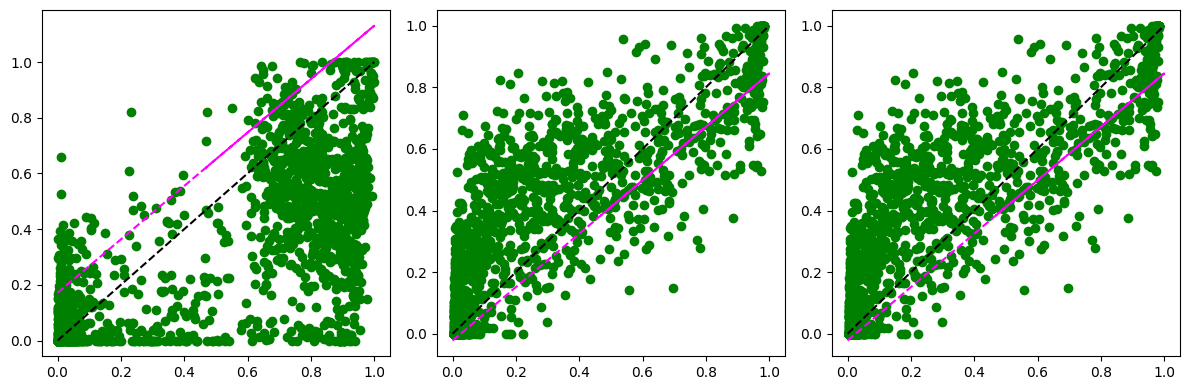

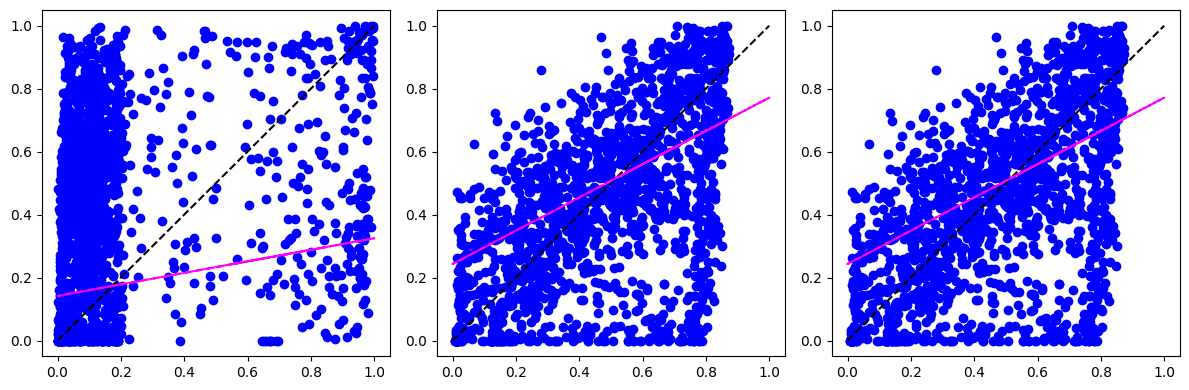

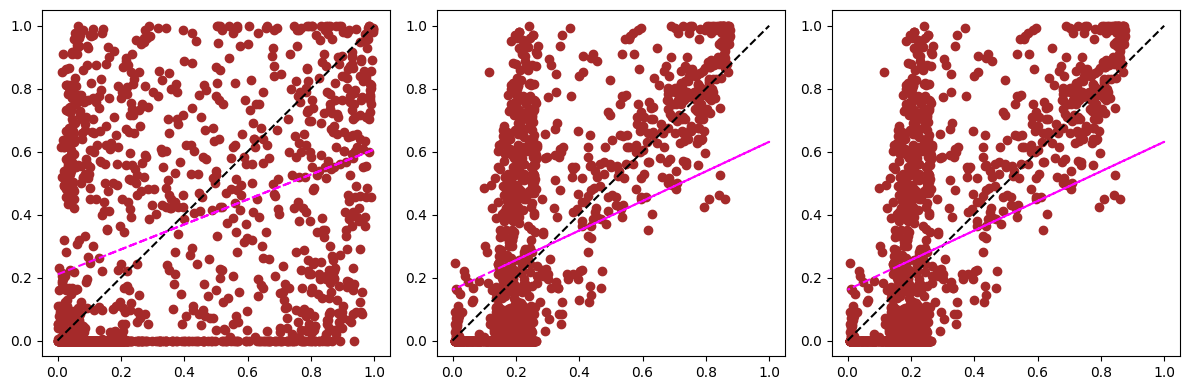

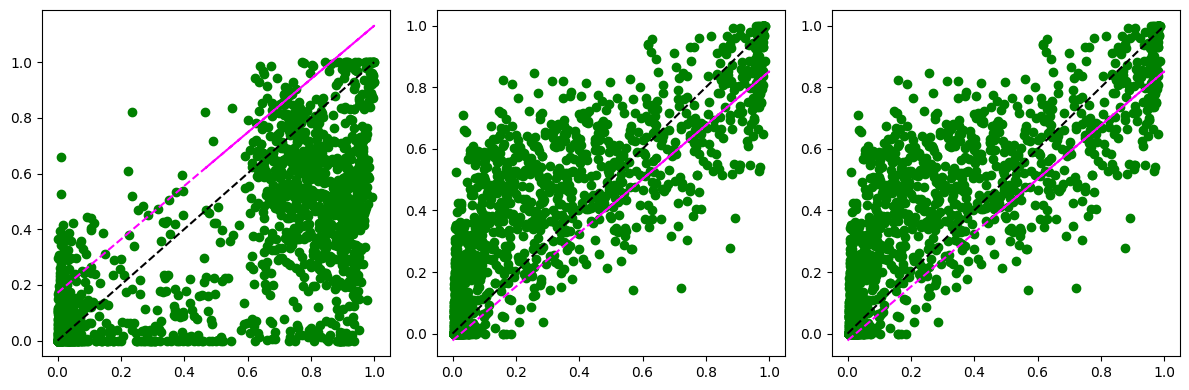

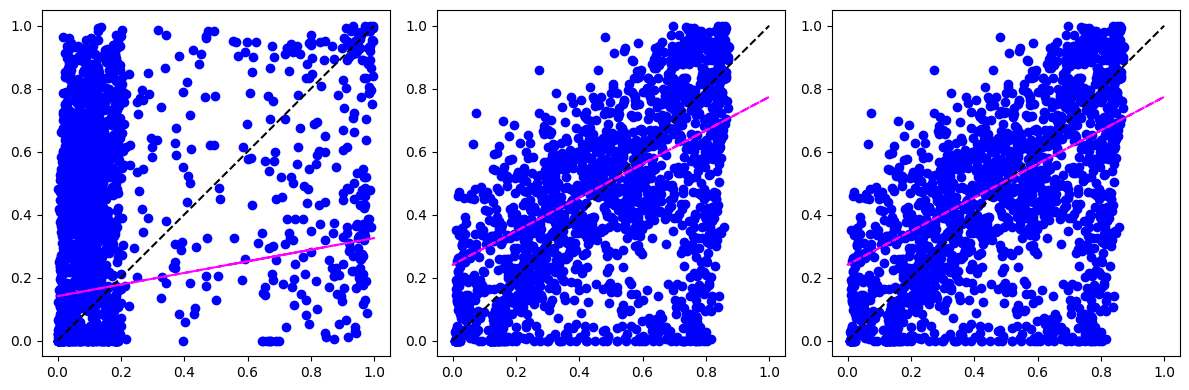

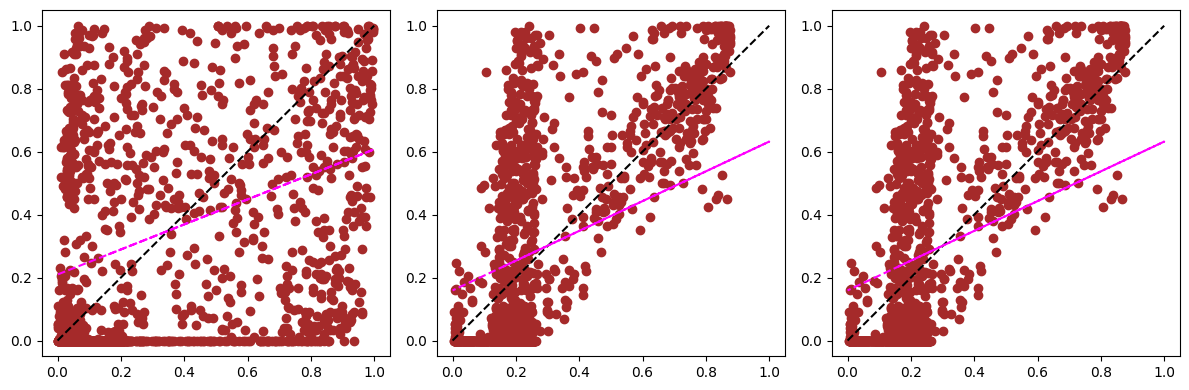

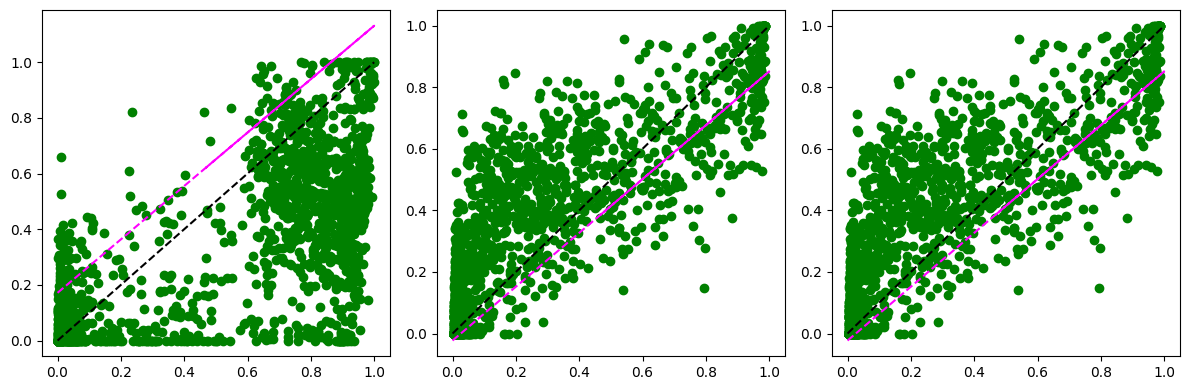

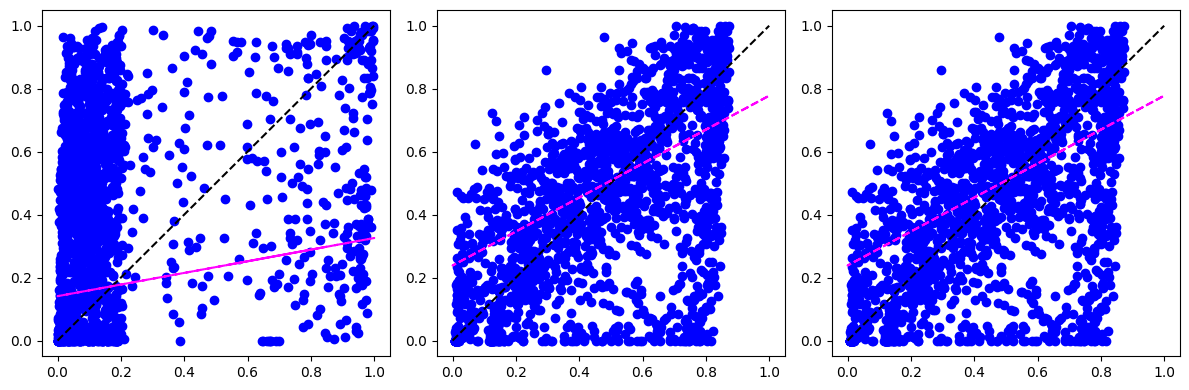

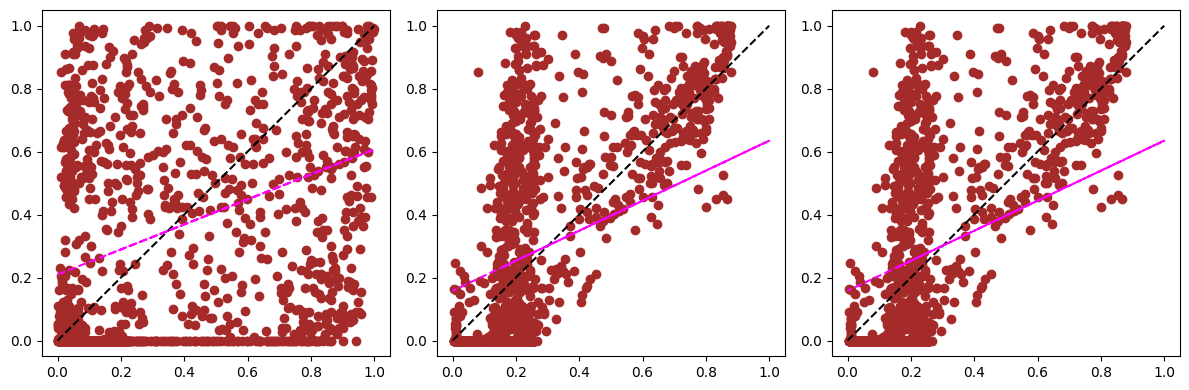

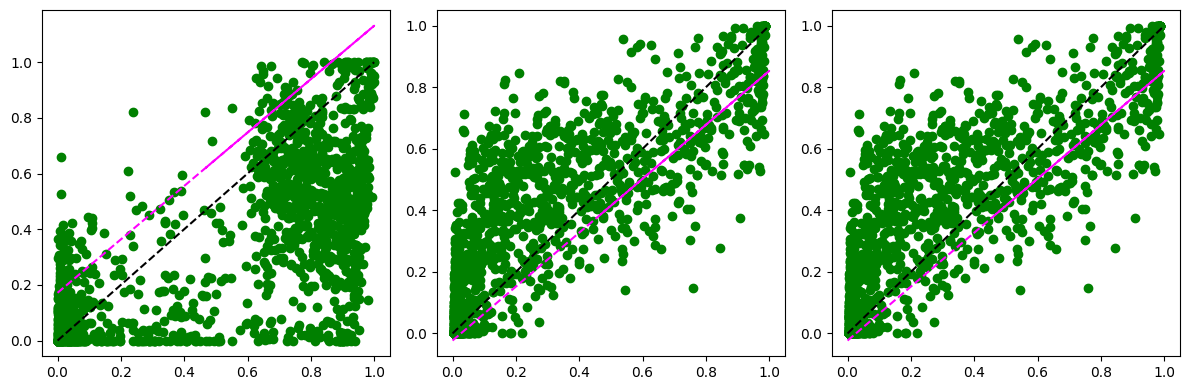

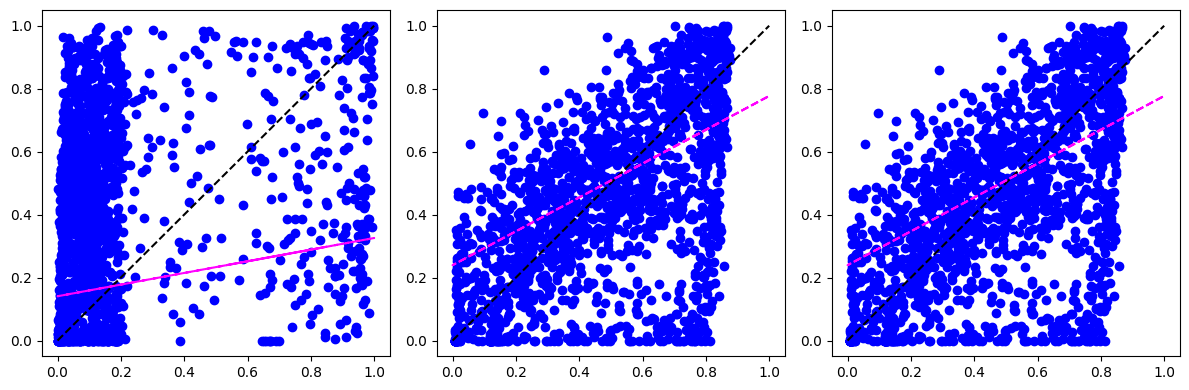

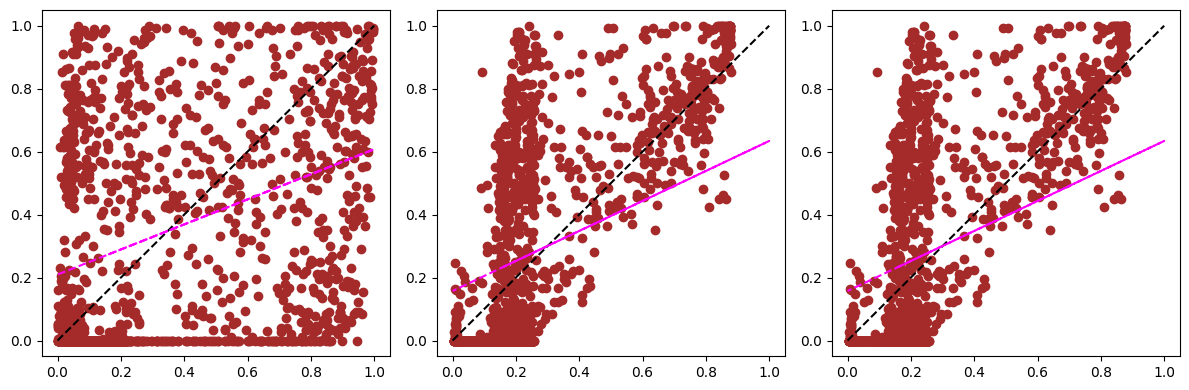

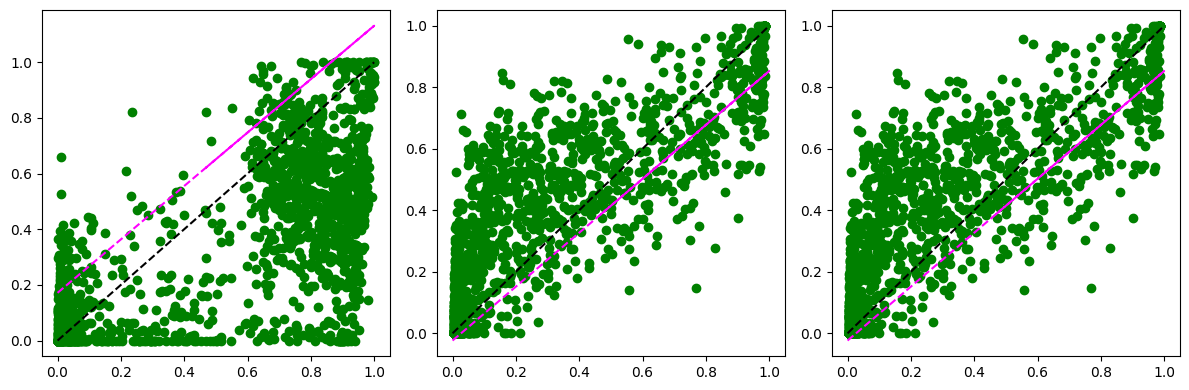

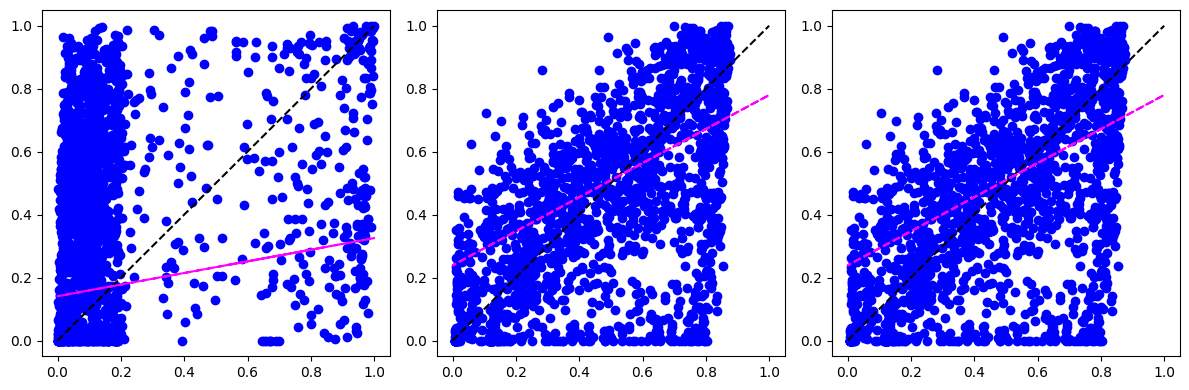

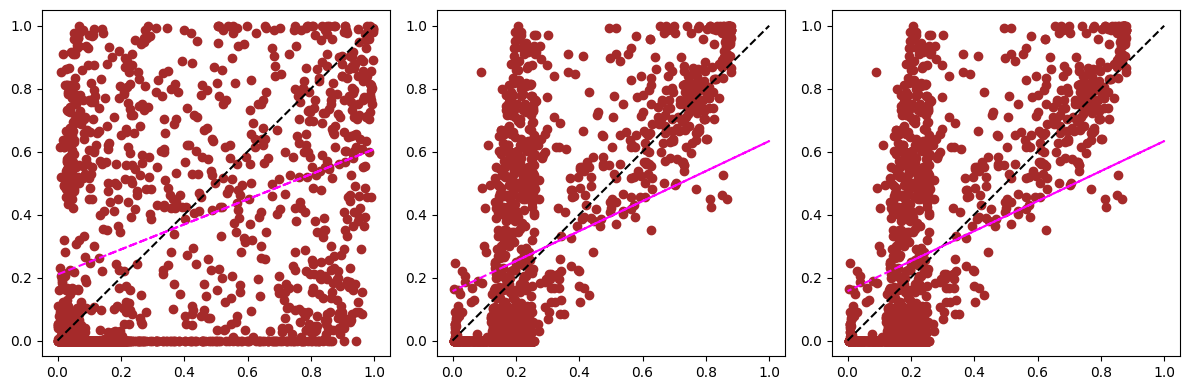

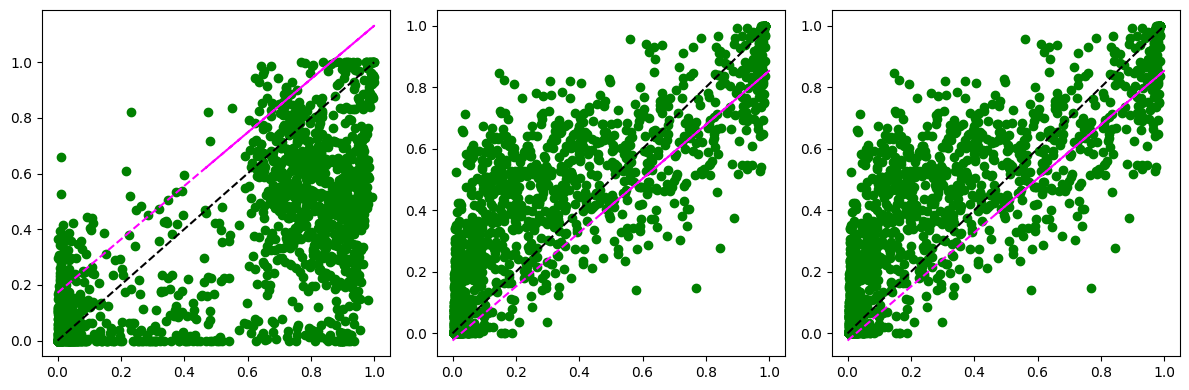

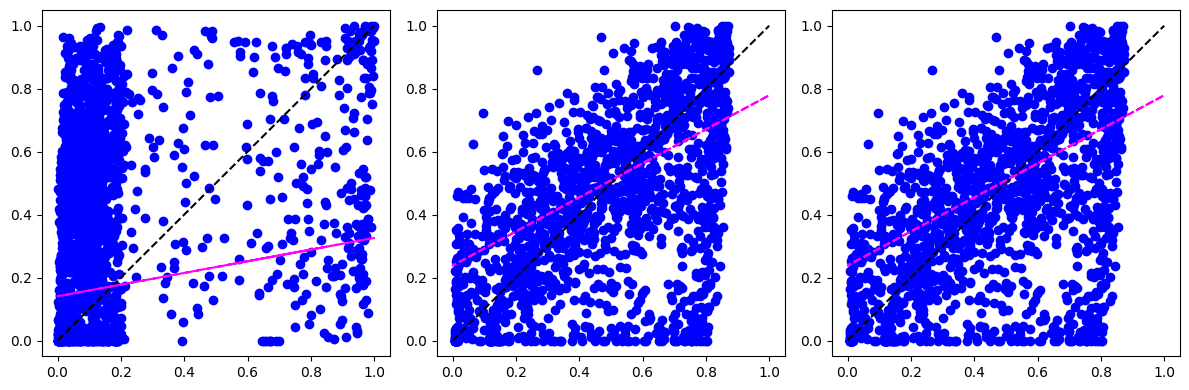

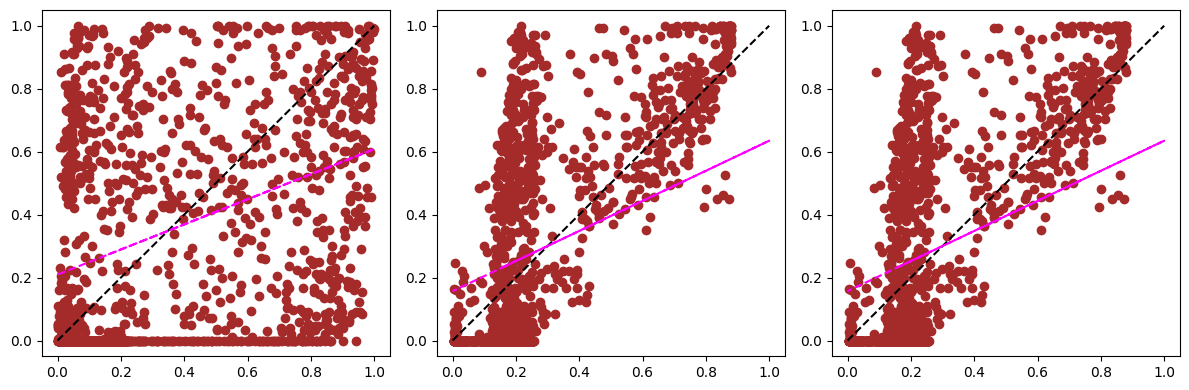

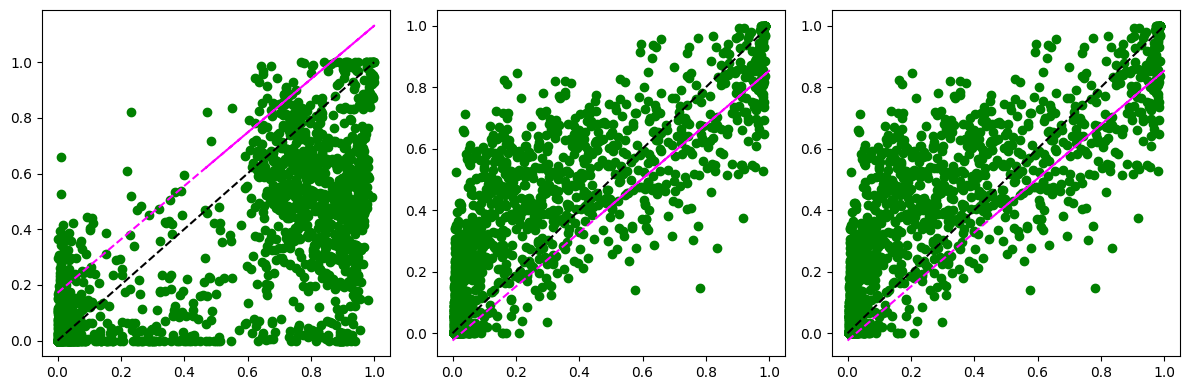

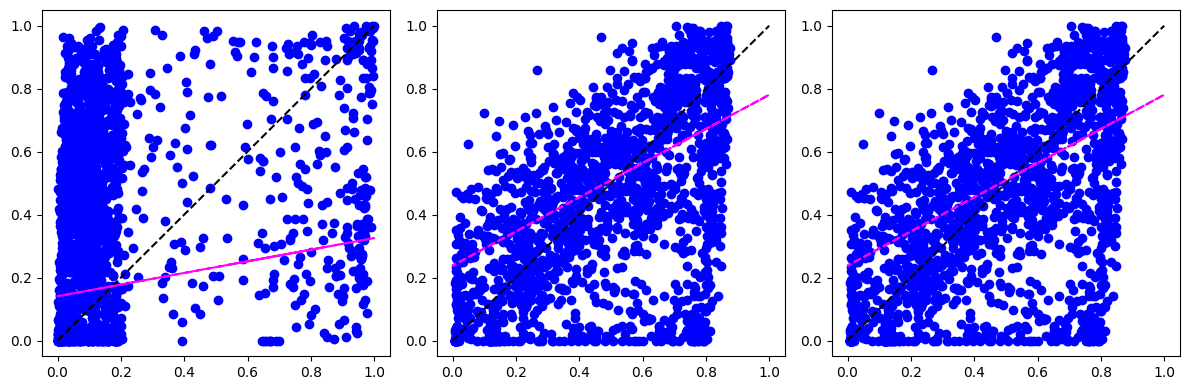

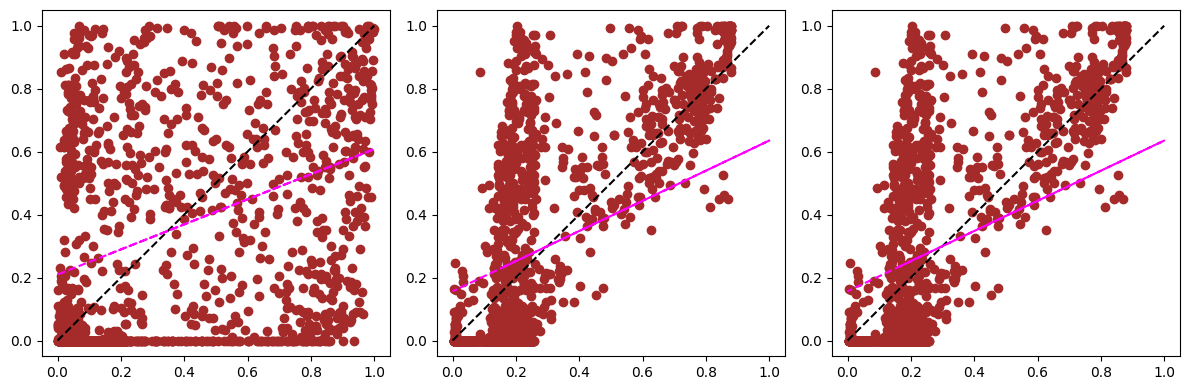

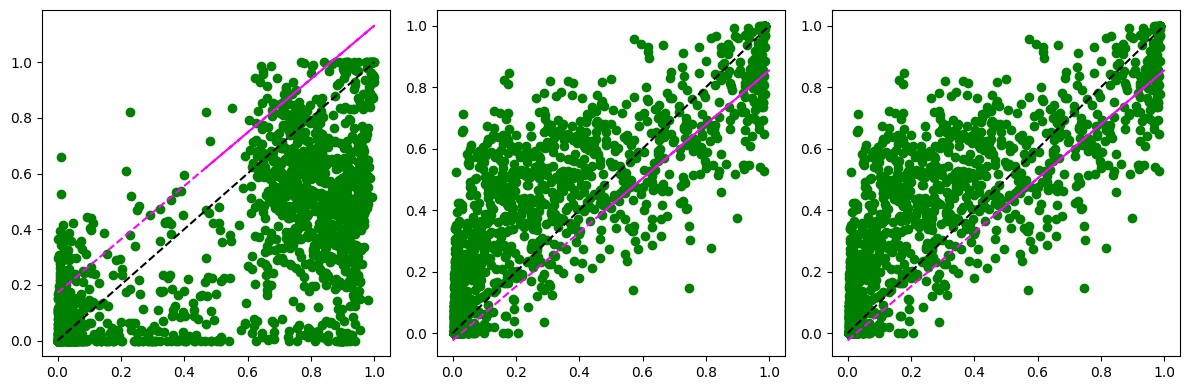

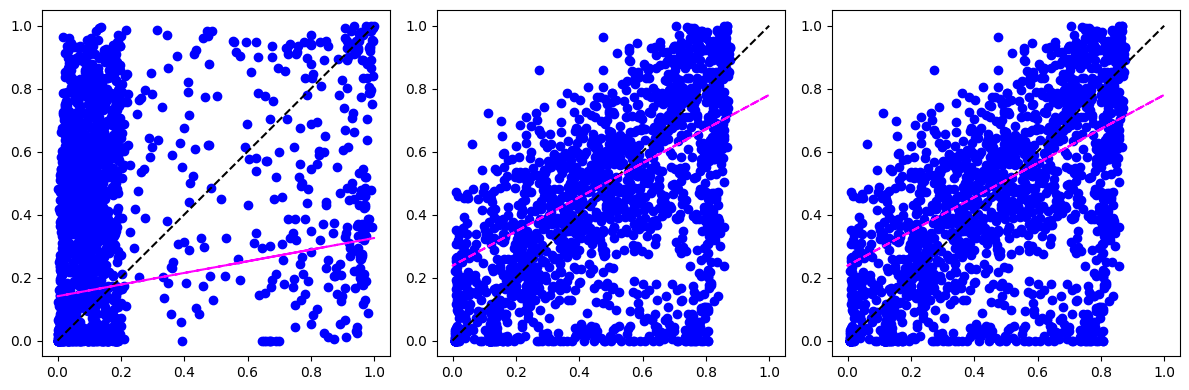

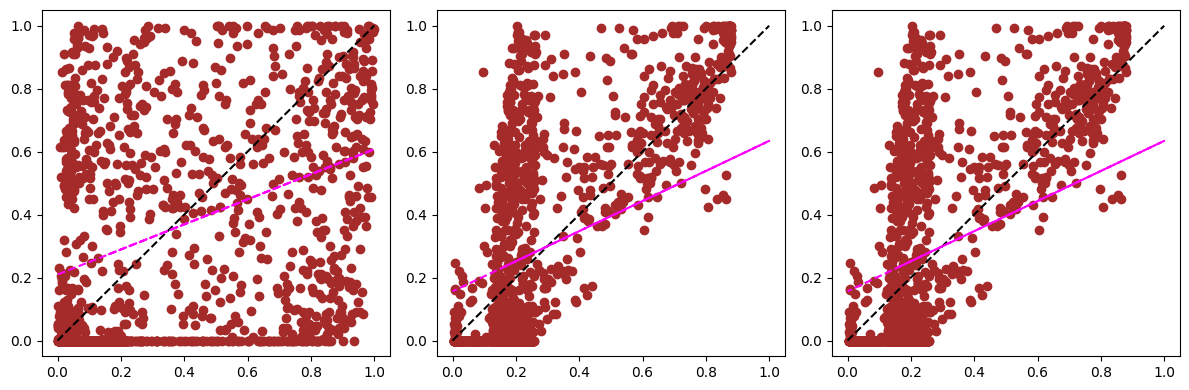

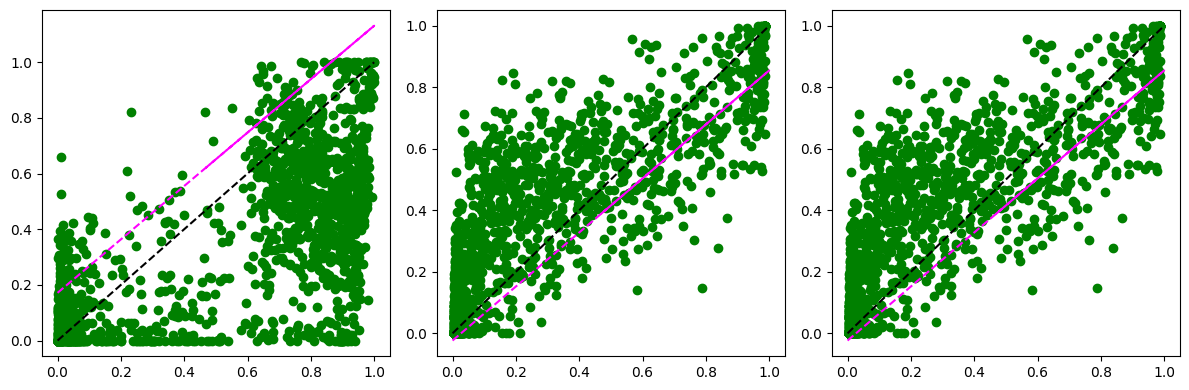

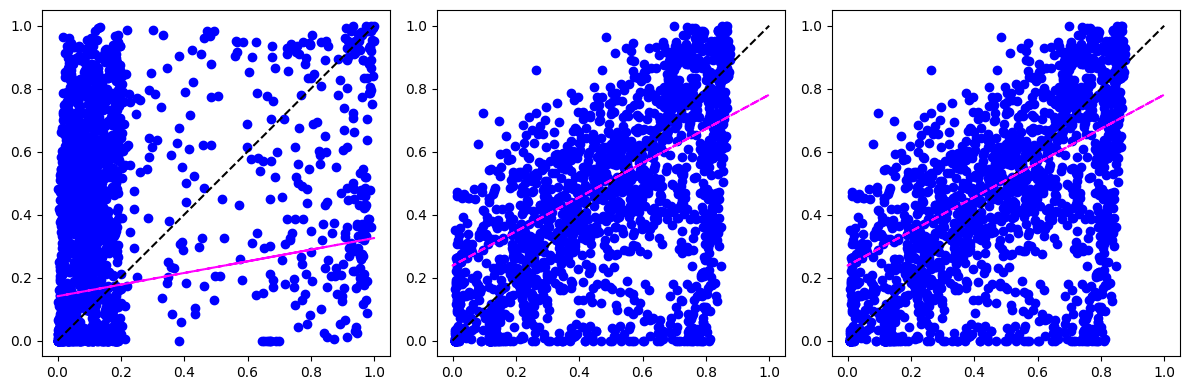

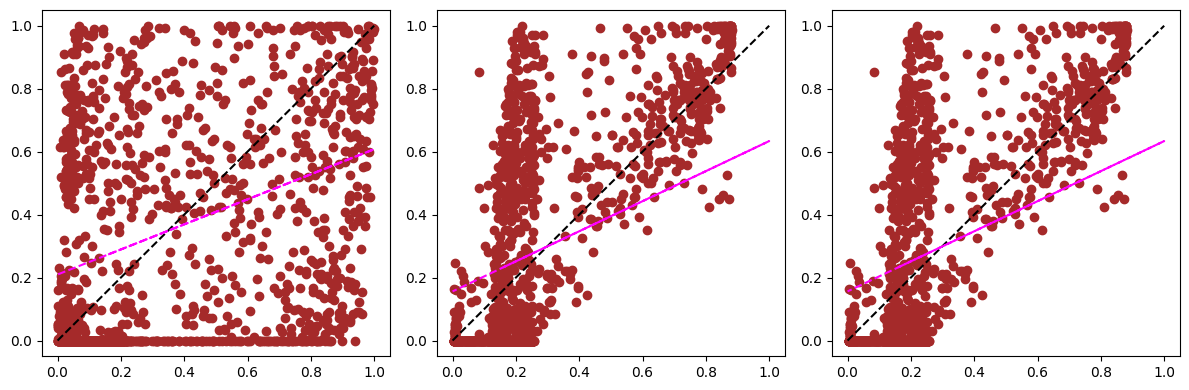

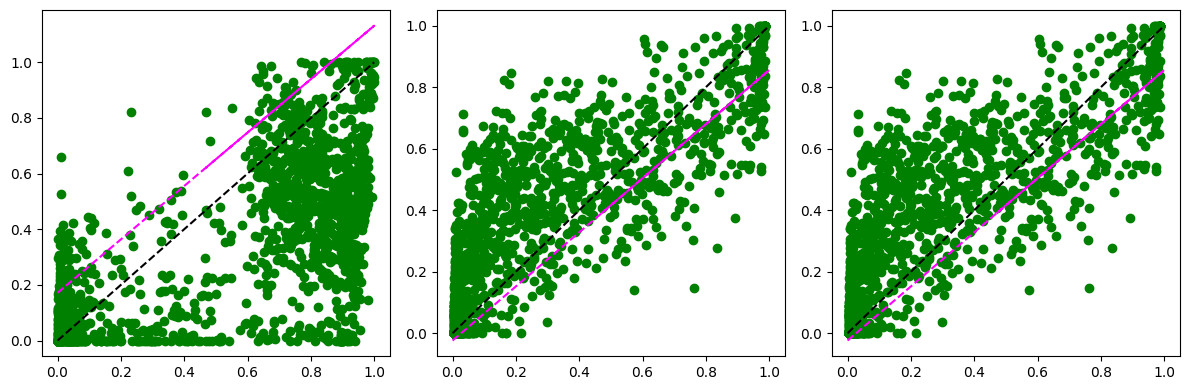

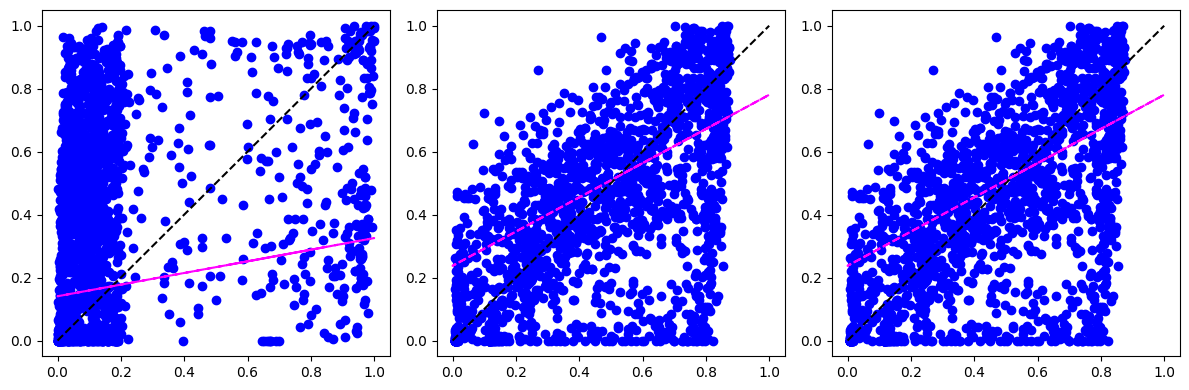

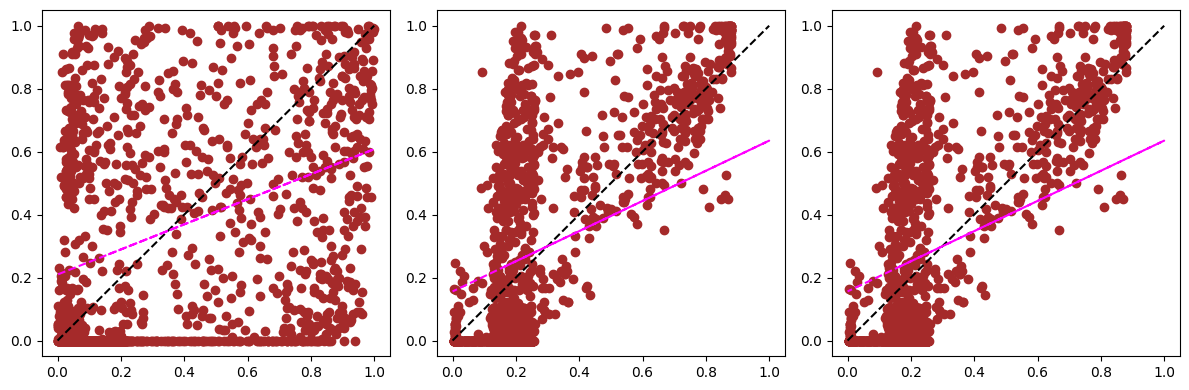

In [60]:
Results = pd.DataFrame(columns=['SNR', 'R^2', 'P-value', 'Standard Error', 'Slope', 'Intercept'])
Results.astype('object')

for i in range(len(SNR_Options)):
    Results.loc[SNR_Options[i], 'SNR'] = SNR_Options[i]
    Results.loc[SNR_Options[i], 'R^2'] = None
    Results.loc[SNR_Options[i], 'P-value'] = None
    Results.loc[SNR_Options[i], 'Standard Error'] = None
    Results.loc[SNR_Options[i], 'Slope'] = None
    Results.loc[SNR_Options[i], 'Intercept'] = None

Results.to_csv(r"C:\SenkDosya\UTAT\Github\FINCH-Science\Pipelines\CSRS2025\Unmixing_SNR.csv", index=False)

for i in SNR_Options:

    globals()[f'Best_Fit_R2_SNR_{i}'] =  [[None, None, None], [None, None, None], [None, None, None]]  # Initialize the list of lists for R^2
    globals()[f'Best_Fit_P_SNR_{i}'] =  [[None, None, None], [None, None, None], [None, None, None]]  # Initialize the list of lists for P-value
    globals()[f'Best_Fit_Std_SNR_{i}'] =  [[None, None, None], [None, None, None], [None, None, None]]  # Initialize the list of lists for Standard Error
    globals()[f'Best_Fit_Slope_SNR_{i}'] =  [[None, None, None], [None, None, None], [None, None, None]]  # Initialize the list of lists for Slope
    globals()[f'Best_Fit_Intercept_SNR_{i}'] =  [[None, None, None], [None, None, None], [None, None, None]]  # Initialize the list of lists for Intercept


    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    globals()[f'Best_Fit_R2_SNR_{i}'][0][0], globals()[f'Best_Fit_P_SNR_{i}'][0][0], globals()[f'Best_Fit_Std_SNR_{i}'][0][0], globals()[f'Best_Fit_Slope_SNR_{i}'][0][0], globals()[f'Best_Fit_Intercept_SNR_{i}'][0][0] = plot3_single_abundance_comparison(ax[0], 0, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_IS_Reg_SNR_{i}']), title=f"IS Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    globals()[f'Best_Fit_R2_SNR_{i}'][1][0], globals()[f'Best_Fit_P_SNR_{i}'][1][0], globals()[f'Best_Fit_Std_SNR_{i}'][1][0], globals()[f'Best_Fit_Slope_SNR_{i}'][1][0], globals()[f'Best_Fit_Intercept_SNR_{i}'][1][0] = plot3_single_abundance_comparison(ax[1], 0, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_ISpdf_Reg_SNR_{i}']), title=f"IS-PDF Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    globals()[f'Best_Fit_R2_SNR_{i}'][2][0], globals()[f'Best_Fit_P_SNR_{i}'][2][0], globals()[f'Best_Fit_Std_SNR_{i}'][2][0], globals()[f'Best_Fit_Slope_SNR_{i}'][2][0], globals()[f'Best_Fit_Intercept_SNR_{i}'][2][0] = plot3_single_abundance_comparison(ax[2], 0, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_KL_Reg_SNR_{i}']), title=f"KL Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    globals()[f'Best_Fit_R2_SNR_{i}'][0][1], globals()[f'Best_Fit_P_SNR_{i}'][0][1], globals()[f'Best_Fit_Std_SNR_{i}'][0][1], globals()[f'Best_Fit_Slope_SNR_{i}'][0][1], globals()[f'Best_Fit_Intercept_SNR_{i}'][0][1] = plot3_single_abundance_comparison(ax[0], 1, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_IS_Reg_SNR_{i}']), title=f"IS Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    globals()[f'Best_Fit_R2_SNR_{i}'][1][1], globals()[f'Best_Fit_P_SNR_{i}'][1][1], globals()[f'Best_Fit_Std_SNR_{i}'][1][1], globals()[f'Best_Fit_Slope_SNR_{i}'][1][1], globals()[f'Best_Fit_Intercept_SNR_{i}'][1][1] = plot3_single_abundance_comparison(ax[1], 1, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_ISpdf_Reg_SNR_{i}']), title=f"IS-PDF Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    globals()[f'Best_Fit_R2_SNR_{i}'][2][1], globals()[f'Best_Fit_P_SNR_{i}'][2][1], globals()[f'Best_Fit_Std_SNR_{i}'][2][1], globals()[f'Best_Fit_Slope_SNR_{i}'][2][1], globals()[f'Best_Fit_Intercept_SNR_{i}'][2][1] = plot3_single_abundance_comparison(ax[2], 1, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_KL_Reg_SNR_{i}']), title=f"KL Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    globals()[f'Best_Fit_R2_SNR_{i}'][0][2], globals()[f'Best_Fit_P_SNR_{i}'][0][2], globals()[f'Best_Fit_Std_SNR_{i}'][0][2], globals()[f'Best_Fit_Slope_SNR_{i}'][0][2], globals()[f'Best_Fit_Intercept_SNR_{i}'][0][2] = plot3_single_abundance_comparison(ax[0], 2, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_IS_Reg_SNR_{i}']), title=f"IS Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    globals()[f'Best_Fit_R2_SNR_{i}'][1][2], globals()[f'Best_Fit_P_SNR_{i}'][1][2], globals()[f'Best_Fit_Std_SNR_{i}'][1][2], globals()[f'Best_Fit_Slope_SNR_{i}'][1][2], globals()[f'Best_Fit_Intercept_SNR_{i}'][1][2] = plot3_single_abundance_comparison(ax[1], 2, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_ISpdf_Reg_SNR_{i}']), title=f"IS-PDF Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    globals()[f'Best_Fit_R2_SNR_{i}'][2][2], globals()[f'Best_Fit_P_SNR_{i}'][2][2], globals()[f'Best_Fit_Std_SNR_{i}'][2][2], globals()[f'Best_Fit_Slope_SNR_{i}'][2][2], globals()[f'Best_Fit_Intercept_SNR_{i}'][2][2] = plot3_single_abundance_comparison(ax[2], 2, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_KL_Reg_SNR_{i}']), title=f"KL Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plt.tight_layout()
    plt.show()

    # Now, we save the results to the Results dataframe

    Results.loc[i, 'R^2'] = globals()[f'Best_Fit_R2_SNR_{i}']
    Results.loc[i, 'P-value'] = globals()[f'Best_Fit_P_SNR_{i}']
    Results.loc[i, 'Standard Error'] = globals()[f'Best_Fit_Std_SNR_{i}']
    Results.loc[i, 'Slope'] = globals()[f'Best_Fit_Slope_SNR_{i}']
    Results.loc[i, 'Intercept'] = globals()[f'Best_Fit_Intercept_SNR_{i}']

"""
In this final saved CSV,

within a list of a column, the first list of that list would represent a different method

[[Reg-RMSE],[Deriv-RMSE],[KL]]

and within each of these lists, there are three values, one for each abundance type's best fit (GV, NPV, Soil).
"""

Results.to_csv(r"C:\SenkDosya\UTAT\Github\FINCH-Science\Pipelines\CSRS2025\Unmixing_SNR.csv", index=False)